In [1]:
import numpy as np
import pandas as pd

import random
from pprint import pprint



In [2]:
df=pd.read_csv("Final_project_data_set_3.csv")
df = df.drop("StartLotKey", axis=1)
df = df.drop("WaferId", axis=1)
df.head()

,P_02281_P,P_04928_P,P_05104_P,P_05844_P,P_06198_P,P_06199_P,P_08812_P,P_09320_P,P_09357_P,P_09360_P,...,P_00882_P,P_03186_P,P_03233_P,P_04800_P,P_05602_P,P_08907_P,P_09529_P,P_00862_P,P_07882_P,Label
0,0.396,-2088.56,3065.0,0.648,100.453,97.434,0.308,0.224,87.929,87.398,...,0.624,21.301,24.218,5.172,518.25,-355.70,-415.9,3.081660e+11,825.7,High
1,0.384,-3104.77,3128.2,0.661,102.576,97.427,0.321,0.207,89.054,87.229,...,1.197,21.437,24.420,5.189,618.95,-351.75,-421.9,9.548818e+10,822.1,High
2,0.390,-2366.22,3086.4,0.649,100.403,96.306,0.305,0.222,88.360,88.016,...,0.757,21.195,24.228,5.063,517.80,-364.05,-412.8,1.523520e+11,822.6,High
3,0.384,-2966.25,3046.4,0.645,101.192,98.182,0.226,0.204,85.025,84.697,...,0.762,21.811,24.470,5.149,585.95,-377.90,-440.7,1.442480e+11,833.7,High
4,0.388,-1883.92,3242.2,0.652,102.502,97.309,0.376,0.237,87.675,87.224,...,1.336,21.398,24.257,6.348,628.85,-347.65,-417.1,1.937050e+11,823.3,High


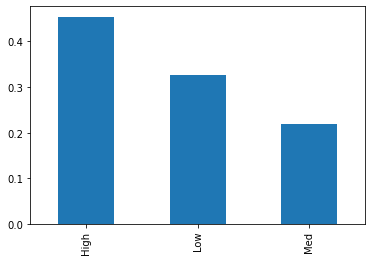

In [3]:
wafer_quality = df.Label.value_counts(normalize=True)
wafer_quality = wafer_quality.sort_index()
wafer_quality.plot(kind="bar")

In [4]:
def train_test_split(df, test_size):
    #df.index
    #RangeIndex(start=0, stop=169, step=1)

    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    #Storing all the indices into one variable
    indices = df.index.tolist()

    test_indices=random.sample(population=indices, k=test_size)

    test_df=df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [5]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size = 0.2)

In [6]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size = n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    
    return df_bootstrapped

In [7]:
#bootstrapping(train_df, n_bootstrap=100)

In [8]:
def classify_data(data):
    
    label_column = data[:,-1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
    
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [9]:
def calculate_accuracy(predictions, labels):
    
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy

In [10]:
def check_purity(data):
    # : --> all rows while -1 would mean last column
    label_column = data[:,-1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [11]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]
    
    return data_below, data_above

In [12]:
def calculate_entropy(data):
    label_column=data[:,-1]
    _,counts = np.unique(label_column, return_counts=True)

    probabilities = counts/counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

In [13]:
def calculate_overall_entropy(data_below, data_above):
    n_data_points = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points

    overall_entropy = (p_data_below * calculate_entropy(data_below)
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [14]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)


            if current_overall_entropy < overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [15]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    #'P_04194_P <= 7316.2305'
    feature_name, comparision_operator, value = question.split()

    #ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part of cunction

    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [16]:
def decision_tree_algorithm(df, counter =0, min_samples=2, max_depth = 5, random_subspace=None):
    
    # data preparations
    if counter ==0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data=df
        
    #base case
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        return classification
    
    # recursive part
    else:
        counter += 1
        
        # helper functions
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # instantiate subtree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # find answers{recursion}
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [17]:
def get_potential_splits(data, random_subspace):
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k = random_subspace)
    
    for column_index in column_indices:
        
        potential_splits[column_index]=[]
        values=data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2

                potential_splits[column_index].append(potential_split)
    
    
    return potential_splits

In [18]:
get_potential_splits(train_df.values, random_subspace=5)

{28: [-0.029,
  0.015,
  0.05,
  0.052500000000000005,
  0.056499999999999995,
  0.064,
  0.069,
  0.07100000000000001,
  0.077,
  0.08449999999999999,
  0.0885,
  0.092,
  0.095,
  0.101,
  0.1085,
  0.1175,
  0.13,
  0.1375,
  0.14,
  0.1455,
  0.151,
  0.1525,
  0.1535,
  0.1545,
  0.16,
  0.1665,
  0.16849999999999998,
  0.16949999999999998,
  0.1765,
  0.185,
  0.1875,
  0.1885,
  0.19399999999999998,
  0.2055,
  0.21400000000000002,
  0.21800000000000003,
  0.2215,
  0.22899999999999998,
  0.2365,
  0.24,
  0.2535,
  0.2655,
  0.2665,
  0.2675,
  0.2745,
  0.2815,
  0.2825,
  0.2835,
  0.287,
  0.2945,
  0.3005,
  0.3035,
  0.3075,
  0.312,
  0.316,
  0.322,
  0.3275,
  0.33099999999999996,
  0.33499999999999996,
  0.3385,
  0.343,
  0.347,
  0.35250000000000004,
  0.361,
  0.372,
  0.3805,
  0.3835,
  0.386,
  0.38749999999999996,
  0.39,
  0.4015,
  0.4125,
  0.4205,
  0.42800000000000005,
  0.4305,
  0.43600000000000005,
  0.4425,
  0.4545,
  0.4675,
  0.47250000000000003,
  0

In [19]:
def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth = dt_max_depth, random_subspace=n_features)
        forest.append(tree)
        
    
    return forest

In [20]:
forest = random_forest_algorithm(train_df, n_trees = 9, n_bootstrap=100, n_features=10, dt_max_depth=5)

In [21]:
len(forest)

9

In [22]:
forest[2]

{'P_16874_P <= -711.8685': [{'P_03233_P <= 24.25': ['Med',
    {'P_00125_P <= 16.259999999999998': [{'P_09357_P <= 85.1075': [{'P_00065_P <= 38.846000000000004': ['Med',
          'High']},
        'Low']},
      'Low']}]},
  {'P_04928_P <= -3114.4300000000003': [{'P_06198_P <= 98.16499999999999': [{'P_03233_P <= 24.28': [{'P_18071_P <= 476.5': ['Med',
          'Low']},
        'Low']},
      {'P_16874_P <= -708.2070000000001': [{'P_16969_P <= -88.011': ['Med',
          'Low']},
        {'P_00864_P <= 222.4715': ['High', 'Med']}]}]},
    {'P_09320_P <= 0.1775': ['Low',
      {'P_08812_P <= 0.0915': ['Med', 'High']}]}]}]}

In [24]:
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

In [25]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    #'P_04194_P <= 7316.2305'
    feature_name, comparision_operator, value = question.split()

    #ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part of cunction

    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [26]:
def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

In [36]:
predictions =  random_forest_predictions(test_df, forest)

In [37]:
predictions

216     Low
98      Med
194     Low
107     Low
10     High
66     High
130    High
124     Low
103     Low
200     Med
77     High
122    High
91      Med
149     Med
55     High
129     Med
35      Low
72     High
203     Med
193     Low
24      Med
158     Med
64      Low
136    High
180     Low
154     Med
37     High
79     High
25      Med
186     Low
18      Med
175     Low
84     High
120     Low
143    High
191     Med
90      Low
111     Med
80      Med
156    High
163    High
52      Low
141    High
208     Med
Name: 0, dtype: object

In [31]:
accuracy = calculate_accuracy(predictions, test_df.Label)
print(accuracy)

0.5454545454545454


In [32]:
accuracies=[]
for i in range(10):
    forest = random_forest_algorithm(train_df, n_trees = 9, n_bootstrap=100, n_features=10, dt_max_depth=5)
    predictions =  random_forest_predictions(test_df, forest)
    accuracy = calculate_accuracy(predictions, test_df.Label)
    print(accuracy)
    accuracies.append(accuracy)
    
print("average accuracy: {}".format(np.array(accuracies).mean()))

0.5454545454545454
0.5227272727272727
0.5454545454545454
0.5681818181818182
0.5227272727272727
0.45454545454545453
0.5227272727272727
0.5454545454545454
0.4090909090909091
0.6363636363636364
average accuracy: 0.5272727272727272


In [33]:
forest = random_forest_algorithm(train_df, n_trees = 1, n_bootstrap=len(train_df), n_features=100, dt_max_depth=5)
predictions =  random_forest_predictions(test_df, forest)
accuracy = calculate_accuracy(predictions, test_df.Label)
print(accuracy)

0.5


In [34]:
accuracies=[]
for i in range(10):
    forest = random_forest_algorithm(train_df, n_trees = 1, n_bootstrap=len(train_df), n_features=100, dt_max_depth=5)
    predictions =  random_forest_predictions(test_df, forest)
    accuracy = calculate_accuracy(predictions, test_df.Label)
    print(accuracy)
    accuracies.append(accuracy)
    
print("average accuracy: {}".format(np.array(accuracies).mean()))

0.45454545454545453
0.4772727272727273
0.4090909090909091
0.4772727272727273
0.36363636363636365
0.45454545454545453
0.4318181818181818
0.29545454545454547
0.45454545454545453
0.36363636363636365
average accuracy: 0.41818181818181815
